In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt

from sklearn.cross_validation import train_test_split
from sklearn import model_selection
from sklearn import neighbors
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Задача 12

Предсказать сорт винограда из которого сделано вино, используя результаты химических анализов, c помощью KNN - метода k ближайших соседей с тремя различными метриками. Построить график зависимости величины ошибки от числа соседей k.

Данные: https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

### Считаем данные

In [210]:
col = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 'Flavanoids',
       'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names = col)
wine.head(3)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [3]:
wine.shape

(178, 14)

Посмотрим, как выглядит распределение вин по классам

Text(0.5, 0, 'Class')

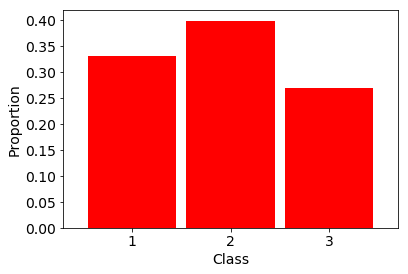

In [4]:
stat = wine.groupby('Class')['Class'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Class', fontsize=14)

Разделим нашу выборку на тестовую и обучающую

In [73]:
X_train, X_test, y_train, y_test = train_test_split(wine.loc[:, wine.columns != 'Class'], wine['Class'], test_size=0.25, 
                                                    stratify=wine[['Class']])

### kNN-метод

Обучим нашу модель метода k ближайших соседей с тремя различными метриками для разных k

In [74]:
used_metrics = ['euclidean', 'manhattan', 'chebyshev']
n_max = 100
accuracy = np.zeros((3, n_max+1))
for i in range(3):
    for num_neighbors in range(1, n_max+1):
        nb = neighbors.KNeighborsClassifier(n_neighbors = num_neighbors, metric = used_metrics[i])
        nb.fit(X_train, y_train)
        prediction = nb.predict(X_test)
        accuracy[i][num_neighbors] = metrics.accuracy_score(y_test, prediction)

Представим полученные результаты на графике и найдём наилучшее значение параметра k в смысле каждой метрики

euclidean: 19
manhattan: 2
chebyshev: 19


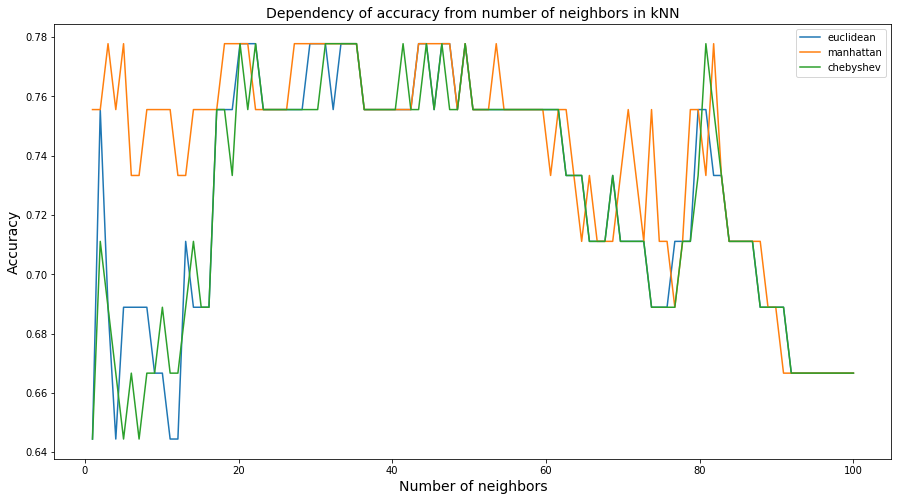

In [207]:
plt.figure(figsize=(15, 8))
for i in range(3):
    plt.plot(np.linspace(1, n_max, n_max-1), accuracy[i][2:], label = used_metrics[i])
    print(used_metrics[i] + ': ' + str(np.argmax(accuracy[i][2:])))
plt.title('Dependency of accuracy from number of neighbors in kNN', fontsize=14)
plt.xlabel('Number of neighbors', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

Сделаем то же самое для суммы метрик

Maximun on 19 neighbors


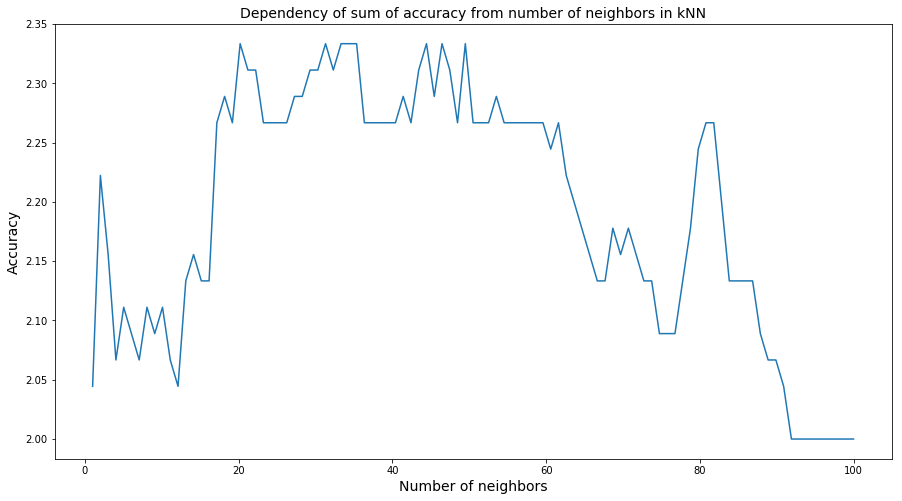

In [208]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(1, n_max, n_max-1), sum(accuracy)[2:])
plt.title('Dependency of sum of accuracy from number of neighbors in kNN', fontsize=14)
plt.xlabel('Number of neighbors', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
print("Maximun on " + str(np.argmax(sum(accuracy)[2:])) + " neighbors")

**Таким образом видим, что в целом качество довольно хорошее, но нет какой-либо четной зависимости от значения k колличества ближайших соседей, за исключением того, что ближе к 100 качество начинает падать. Оно и понятно, так как в нашей выбоке всего 174 элемента, а мы берём больше половины выборки и по всем этим точкам определяем класс одной.**

## Результаты вне задания

Посчитаем среднеквадратичную функцию потерь

In [77]:
nb = neighbors.KNeighborsClassifier(n_neighbors = np.argmax(sum(accuracy)[2:]))
nb.fit(X_train, y_train)
prediction = nb.predict(X_test)
sqrt(metrics.mean_squared_error(y_test, prediction))

0.4944132324730442

Видим, что её значение не самое лучшее, поэтому не будем останавливаться на требованиях задания и попробуем улучшить модель

Посмотрим как располагаются облака точкек по каждой из характеристик в зависимости от класса

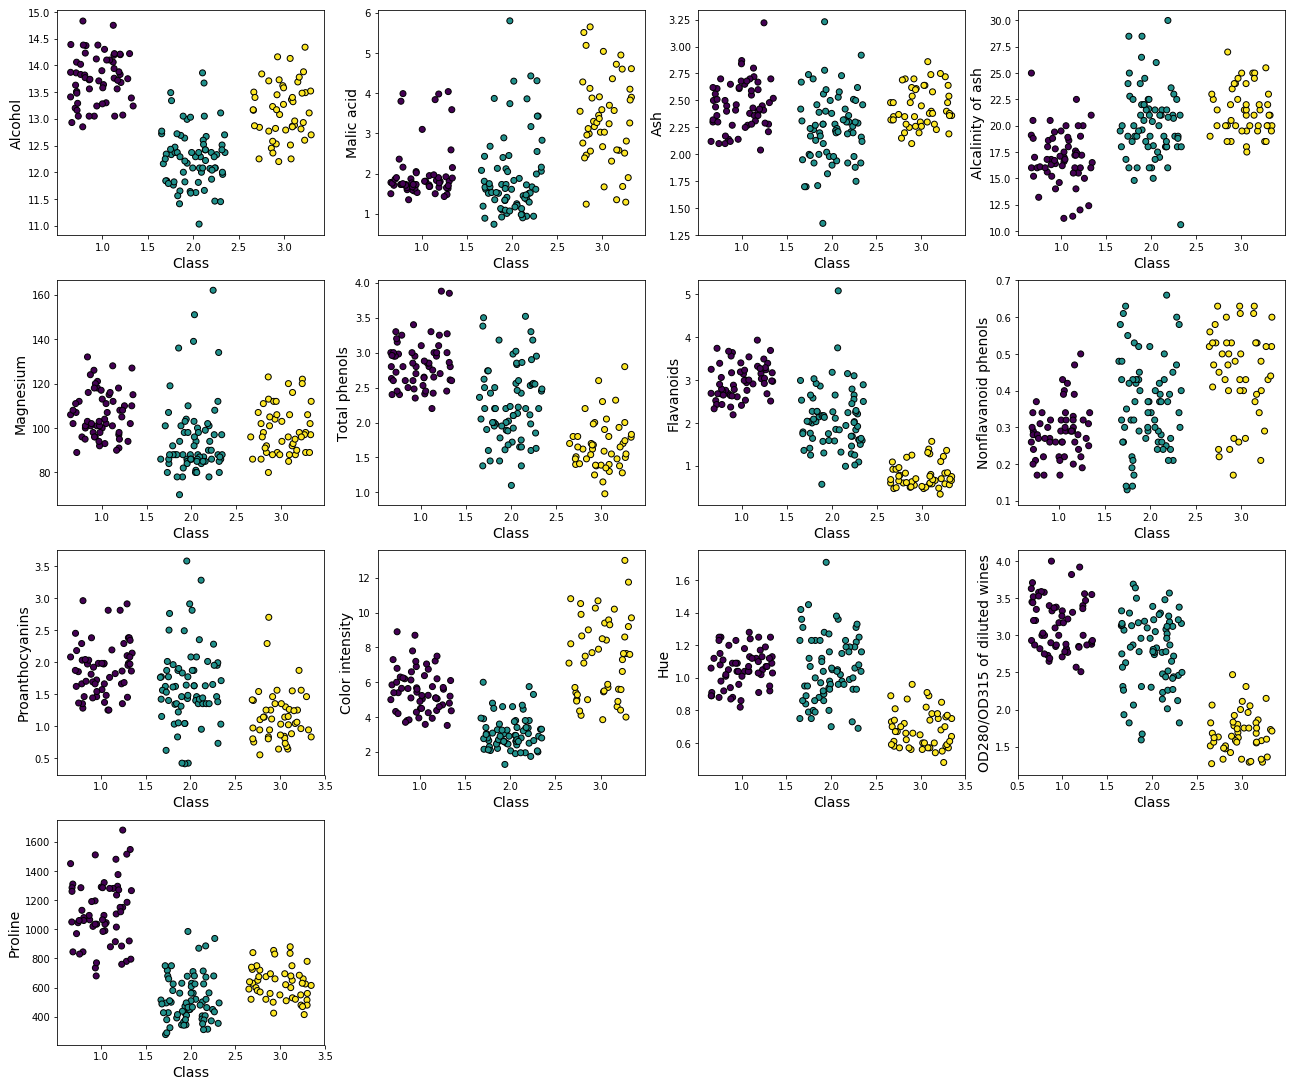

In [78]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

plt.figure(figsize = (22, 24))
for i in range (1, 14):
    plt.subplot(5, 4, i)
    plt.scatter(jitter(wine['Class']), wine.iloc[:, i], c=wine["Class"], edgecolors="black")
    plt.xlabel('Class', fontsize=14)
    plt.ylabel(str(wine.columns[i]), fontsize=14)

Видим, что классы довольно не плохо разделяются по некоторым признакам -- применим алгоритм построения случайного леса

### Random Forest

In [79]:
rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=3)

In [80]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Посчитаем среднеквадратичную функцию потерь

In [81]:
sqrt(metrics.mean_squared_error(rf.predict(X_train), y_train))

0.086710996952412

In [82]:
sqrt(metrics.mean_squared_error(rf.predict(X_test), y_test))

0.14907119849998599

**Видим, что нам удалось кратно улучшить качество по сравнению с kNN**

И это объяснимо, если мы посмотрим, какие вообще классы предсказываются нашими моделями

Text(0.5, 0, 'Class')

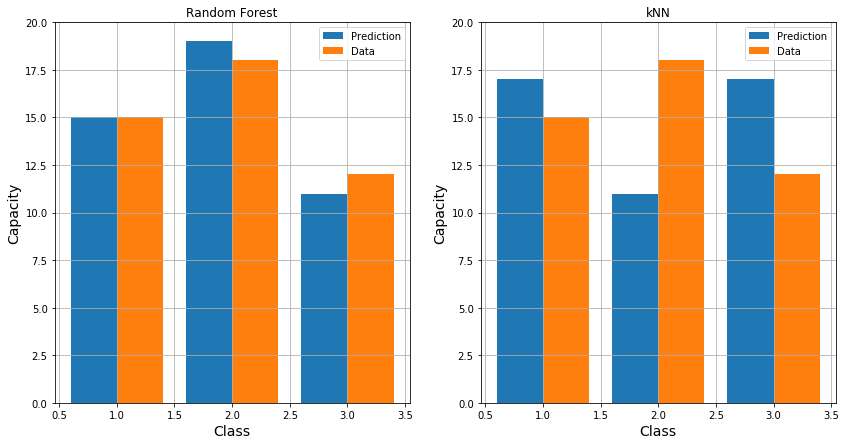

In [209]:
plt.figure(figsize = (14,7))

plt.subplot(121)
plt.hist([rf.predict(X_test), y_test], bins=3, range=[0.5, 3.5], label=['Prediction', 'Data'])
plt.title('Random Forest')
plt.legend()
plt.grid()
plt.ylabel('Capacity', fontsize=14)
plt.ylim(top = 20)
plt.xlabel('Class', fontsize=14)

plt.subplot(122)
plt.hist([nb.predict(X_test), y_test], bins=3, range=[0.5, 3.5], label=['Prediction', 'Data'])
plt.title('kNN')
plt.legend()
plt.grid()
plt.ylabel('Capacity', fontsize=14)
plt.ylim(top = 20)
plt.xlabel('Class', fontsize=14)

### Ещё один интересный факт

Посмотрим, какие признаки обладают наибольшей предсказательной способностью **в определении сорта винограда**, из которого было сделано вино:

In [84]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
0,Alcohol,0.213719
11,OD280/OD315 of diluted wines,0.153593
10,Hue,0.141932
12,Proline,0.121977
4,Magnesium,0.091094
9,Color intensity,0.091038
8,Proanthocyanins,0.081232
6,Flavanoids,0.048706
1,Malic acid,0.024899
3,Alcalinity of ash,0.023975
